In [1]:
import numpy as np
import xgboost as xgb
import yaml

from skimage import io
from sklearn.metrics import jaccard_score, f1_score
from skimage import morphology

import matplotlib.pyplot as plt
import PIL

In [2]:
# Increase the limit of allowed images size
PIL.Image.MAX_IMAGE_PIXELS = 10e10

In [3]:
# Set the lame names
lame = "12AG01290_19"
slide = "PANCKm-CD8r"
label = "Stroma"

In [4]:
# Load the model file
model = xgb.Booster()
model.load_model(f"models/xgboost_{label}.model")

# Set the model to use GPU
model.set_param({'device':'gpu'})

In [5]:
# Load the model parameters
with open(f"models/xgboost_{label}.yaml", "r") as f:
    model_params = yaml.safe_load(f)

# Extract the model parameters
threshold = model_params["threshold"]
min_size = model_params["min_size"]

In [6]:
# Cut the image into vertical tiles
img_tiles = np.array_split(ary=io.imread(f'data/{lame}/results/images_aligned/{slide}.ome.tiff'), 
                           indices_or_sections=100,
                           axis=1)

In [7]:
# Apply the model to each image tile
mask_tiles = []
for img_tile in img_tiles:
    # Transform the image into a 2D matrix
    dtest = xgb.DMatrix(img_tile.reshape(-1, 3))

    # Predict the mask
    preds = model.predict(dtest)

    # Append the mask to the mask_tiles list
    mask_tiles.append(preds.reshape(img_tile.shape[:2]) > threshold)

In [17]:
# Concatenate the mask tiles into a single mask
mask = np.concatenate(mask_tiles, axis=1)

# Clean the mask
mask_clean = morphology.remove_small_objects(mask, min_size=min_size)

In [18]:
# Load the ground truth mask
mask_gt = io.imread(f'data/{lame}/results/masks/{slide}_{label}_mask.png')[:,:mask.shape[1]] > 0

In [19]:
# Compress the predicted, cleaned and ground truth masks
mask_compressed = mask[::100, ::100]
mask_clean_compressed = mask_clean[::100, ::100]
mask_gt_compressed = mask_gt[::100, ::100]

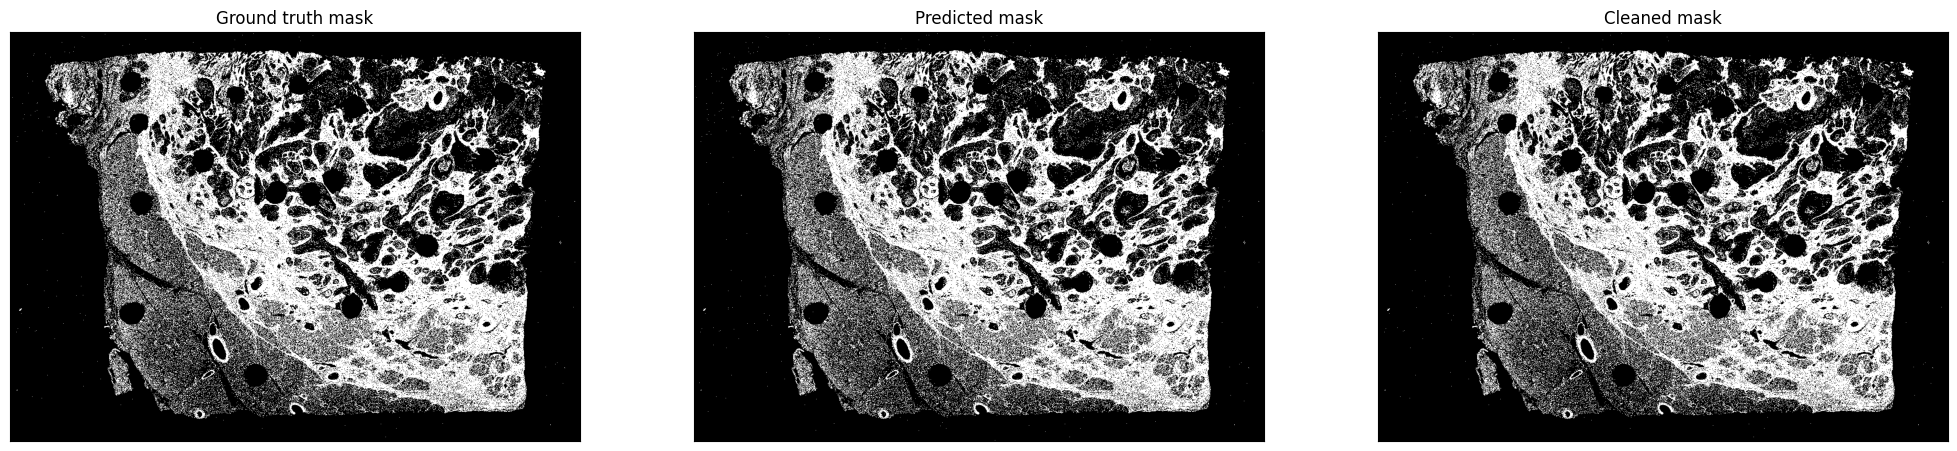

In [27]:
# Plot a compressed version of the mask
fig, ax = plt.subplots(1, 3, figsize=(25, 10))

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

ax[0].imshow(mask_gt_compressed, cmap='gray')
ax[0].set_title('Ground truth mask')
ax[1].imshow(mask_compressed, cmap='gray')
ax[1].set_title('Predicted mask')
ax[2].imshow(mask_clean_compressed, cmap='gray')
ax[2].set_title('Cleaned mask')

plt.show()

In [21]:
# Comput the intersection over union (IOU)
iou = jaccard_score(mask_gt_compressed.ravel(), mask_compressed.ravel()) # Predicted vs ground truth mask
iou_clean = jaccard_score(mask_gt_compressed.ravel(), mask_clean_compressed.ravel()) # Cleaned vs ground truth mask

# Compute the F1 score
f1 = f1_score(mask_gt_compressed.ravel(), mask_compressed.ravel()) # Predicted vs ground truth mask
f1_clean = f1_score(mask_gt_compressed.ravel(), mask_clean_compressed.ravel()) # Cleaned vs ground truth mask

print(f"IOU of {label} in {slide} before cleaning = {iou:.4f}")
print(f"IOU of {label} in {slide} after  cleaning = {iou_clean:.4f}")

print(f"F1 of {label} in {slide} before cleaning = {f1:.4f}")
print(f"F1 of {label} in {slide} after  cleaning = {f1_clean:.4f}")

IOU of Stroma in PANCKm-CD8r before cleaning = 0.9852
IOU of Stroma in PANCKm-CD8r after  cleaning = 1.0000
F1 of Stroma in PANCKm-CD8r before cleaning = 0.9926
F1 of Stroma in PANCKm-CD8r after  cleaning = 1.0000


In [16]:
# Save the mask and the compressed mask
PIL.Image.fromarray(mask_clean).save(f"data/{lame}/results/masks/{slide}_{label}_mask.png")
PIL.Image.fromarray(mask_clean_compressed).save(f"data/{lame}/results/masks/{slide}_{label}_mask_compressed.png")